In [1060]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

import warnings
import importlib
try:
    importlib.reload(utils) # reload module
except NameError:
    pass

# Read Dataset

First thing to do is to read the dataset.

In [1061]:
path= 'input/dataset.csv'
df= pd.read_csv(path, delimiter= '\t')

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Clean Data

We clean the dataset with a function that is located in `utils.py`.

In [1062]:
df_clean= utils.clean_df(df)

After that, we need to remove the outliers. This is the best parctice, since leaving outliers in the dataset tend to mess with the clustering  model, making our segmentation biased. 

For this purpose, we will remove outliers with IQR method.

In [1063]:
cols_to_check= ['income', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       ]
df_clean= utils.drop_outliers(df_clean, columns= cols_to_check, method= 'iqr')

# Preprocessing

Now, we preprocess the dataset so that our clustring model can best use it. What we will do is:
1. One-hot encode categorical features
2. Scale the features
3. Impute missing values

In [1064]:
df_preprocessed= utils.preprocess_df(df_clean)

df_preprocessed.head()

,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,...,education_University,marital_status_Have Partner,marital_status_No Partner,marital_status_Unknown,age_basket_10-19,age_basket_20-29,age_basket_30-39,age_basket_40-49,age_basket_50-59,age_basket_60+
0,0.294302,0.306529,0.977810,1.544839,1.755382,2.456211,1.498520,0.862852,0.394133,1.503583,...,0.993281,-1.346438,1.351737,-0.042438,-0.056178,-0.324523,-0.575101,-0.657106,1.945494,-0.407606
1,-0.267563,-0.384551,-0.874339,-0.638030,-0.732124,-0.652641,-0.637062,-0.738468,-0.161952,-1.168215,...,0.993281,-1.346438,1.351737,-0.042438,-0.056178,-0.324523,-0.575101,-0.657106,-0.514008,2.453350
2,0.936250,-0.799199,0.357459,0.566311,-0.174738,1.340682,-0.146123,-0.035449,-0.718037,1.503583,...,0.993281,0.742700,-0.739789,-0.042438,-0.056178,-0.324523,-0.575101,1.521823,-0.514008,-0.407606
3,-1.205975,-0.799199,-0.874339,-0.562759,-0.667633,-0.506342,-0.587968,-0.757996,-0.161952,-0.786529,...,0.993281,0.742700,-0.739789,-0.042438,-0.056178,-0.324523,1.738824,-0.657106,-0.514008,-0.407606
4,0.301686,1.550473,-0.393492,0.415768,-0.216197,0.152003,0.001158,-0.562713,1.506303,0.358527,...,-1.006764,0.742700,-0.739789,-0.042438,-0.056178,-0.324523,1.738824,-0.657106,-0.514008,-0.407606


# Model and K Selection

## Hopkins Test

Hopkins test is a test that is used basically to determine if the data has group, i.e. we can group them into meaningful groups.

In [1065]:
result= utils.hopkins_test(df_preprocessed)
print(result)

Hopkins statistic =  0.876: there are meaningful clusters


## Model Selection

After that, we will choose our model and the number of cluster using silhouette score as metrics. We will not display each silhouette score, but we will just check it and print that in DF.

We will check which one performs the best in our dataset among:
1. KMeans algorithm
2. Agglomerative clustering
3. Birch

Other than that, we will see what values of k (cluster) is the best.

In [1066]:
clusters= range(2, 6, 1)

models= []
n_clusters= []
silhouette_scores= []
min_n_samples= []

def append_scores(model, i, cluster_labels):
    n_clusters.append(i)
    
    models.append(type(model).__name__)
    
    silhouette_scores.append(silhouette_score(df_preprocessed, cluster_labels))
    
    min_n_sample= np.unique(cluster_labels, return_counts= True)[1].min()
    min_n_samples.append(min_n_sample)


for i in tqdm(clusters):
    
    # k-means
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        kmeans= KMeans(n_clusters= i, random_state= 8, init= 'k-means++', n_init= 10)
        cluster_labels= kmeans.fit_predict(df_preprocessed)
        append_scores(kmeans, i, cluster_labels)

    # agglomerative clustering
    agglo= AgglomerativeClustering(n_clusters= i)
    cluster_labels= agglo.fit_predict(df_preprocessed)
    append_scores(agglo, i, cluster_labels)

    # DBSCAN
    birch= Birch()
    cluster_labels= birch.fit_predict(df_preprocessed)
    append_scores(birch, i, cluster_labels)

results= pd.DataFrame(data= {
    'model': models, 
    'n_clusters': n_clusters, 
    'silhouette_score': silhouette_scores, 
    'min_n_samples': min_n_samples,
}).sort_values('silhouette_score', ignore_index= True)
results

100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


,model,n_clusters,silhouette_score,min_n_samples
0,KMeans,5,0.098234,278
1,KMeans,4,0.109082,408
2,AgglomerativeClustering,3,0.130858,465
3,AgglomerativeClustering,5,0.135038,4
4,AgglomerativeClustering,4,0.135990,7
5,Birch,2,0.145440,415
6,Birch,3,0.145440,415
7,Birch,4,0.145440,415
8,Birch,5,0.145440,415
9,KMeans,3,0.153280,559


We see that KMeans with 5 clusters performs the best. Therefore, we will use that.

# Segmentation

Now we will use Kmeans to label our samples to 5 different clusters / group.

In [1067]:
kmeans= KMeans(n_clusters= 4, random_state= 8, init= 'k-means++', n_init= 10)

map_segment= {
    0: 'Young Families', 
    1: 'Premium Seniors', 
    2: 'Established Households', 
    3: 'Individual Shoppers'
}

def map_array_to_dict(dict_, element):
    return dict_.get(element, 'Not Found')

df_clean= (df_clean
    .assign(
        segment= kmeans.fit_predict(df_preprocessed)
    )
    .assign(
        segment= lambda df_: df_['segment'].map(
            lambda x: map_segment.get(x))
    )
)

# Segment Profiling

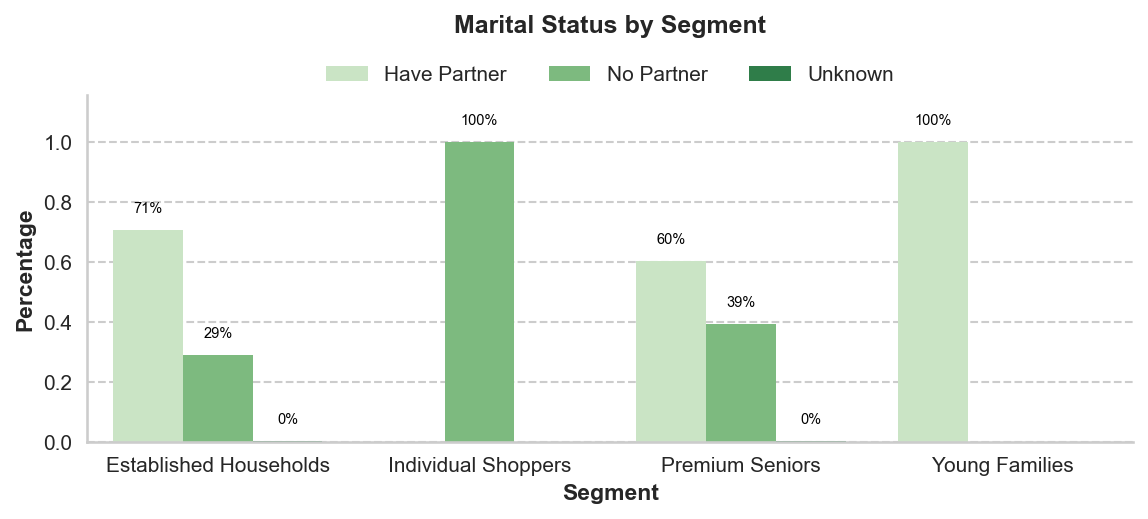

In [1068]:
utils.plot_bar_with_hue(df= df_clean, 
                        hue= 'marital_status')

Every young family in the dataset has a partner, indicating that they are likely married or in committed relationships. In contrast, established households and premium seniors exhibit a more varied pattern; some individuals in these groups have partners, while others do not. This suggests a mix of family structures within these two segments.

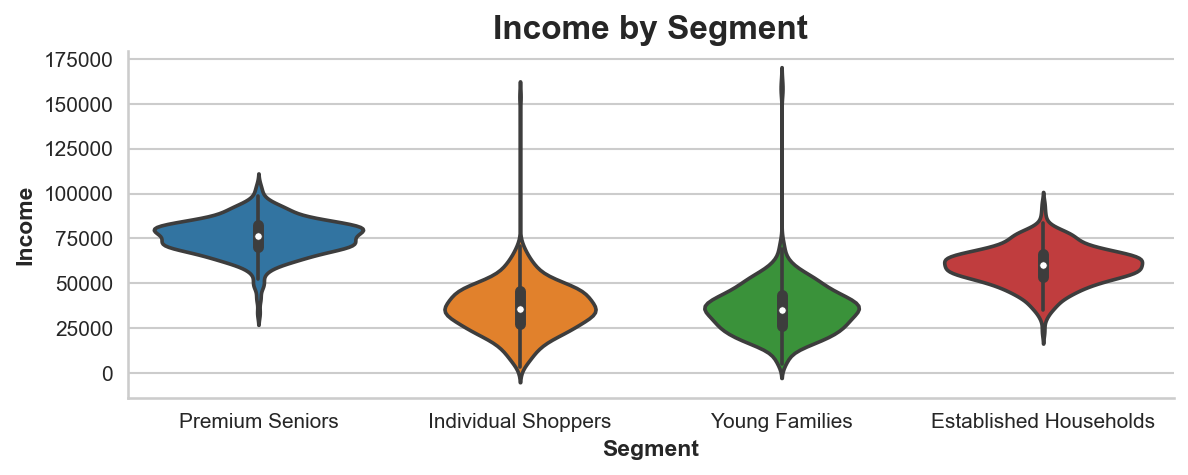

In [1069]:
utils.plot_violin(x= 'segment', 
            y= 'income', 
            df= df_clean)

In this observation, premium seniors have the highest earnings, while individual shoppers and young families earn the lowest incomes.

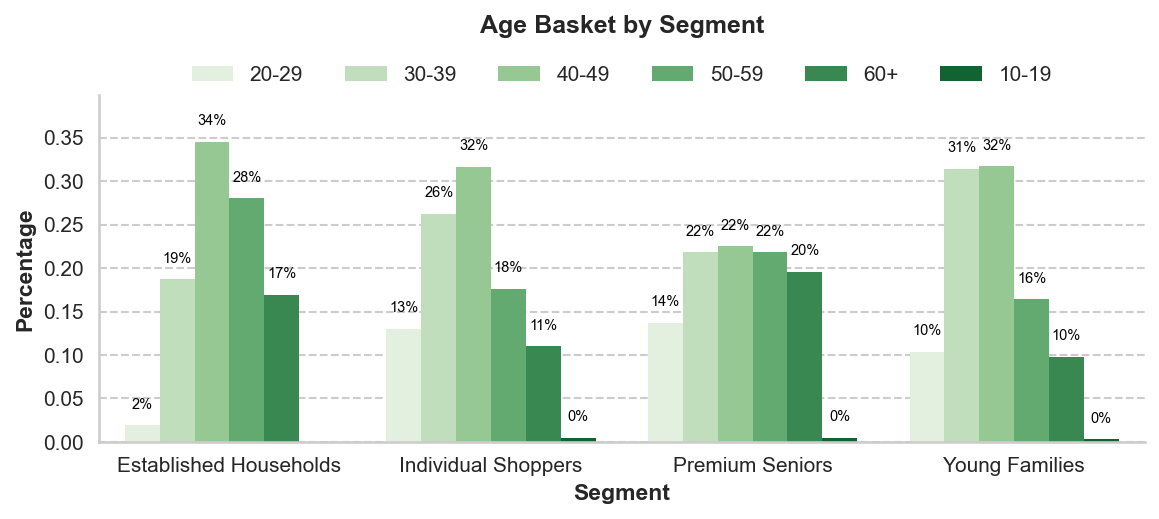

In [1070]:
utils.plot_bar_with_hue(df= df_clean, 
                        hue= 'age_basket')

Regarding age, premium seniors are generally older compared to the other groups.

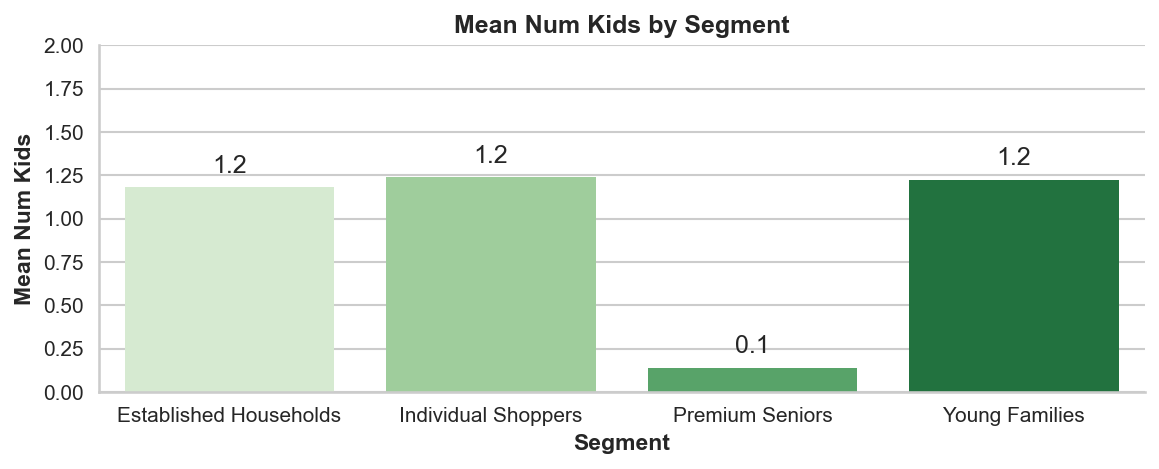

In [1071]:
data= (df_clean
    .groupby('segment')
    .agg(mean_num_kids= ('num_kids', 'mean'))
    .reset_index()
)
plot_bar(
    x= 'segment', 
    y= 'mean_num_kids', 
    df= data, 
    ylim= (0, 2)
)


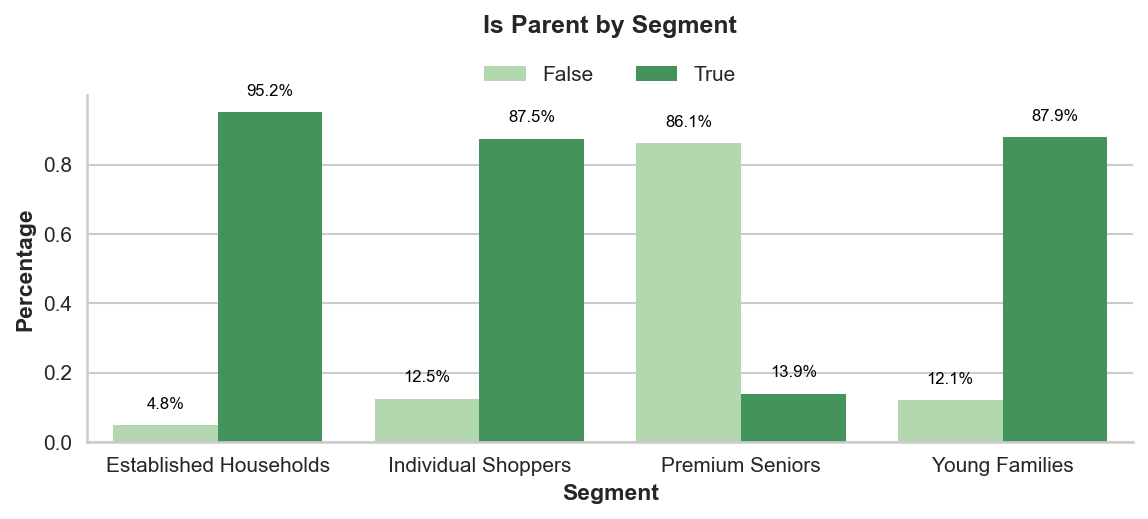

In [1072]:
plot_bar_with_hue(df= df_clean, 
                  hue= 'is_parent')

On average, all groups have approximately 1.2 children, except for premium seniors, who have nearly zero children.

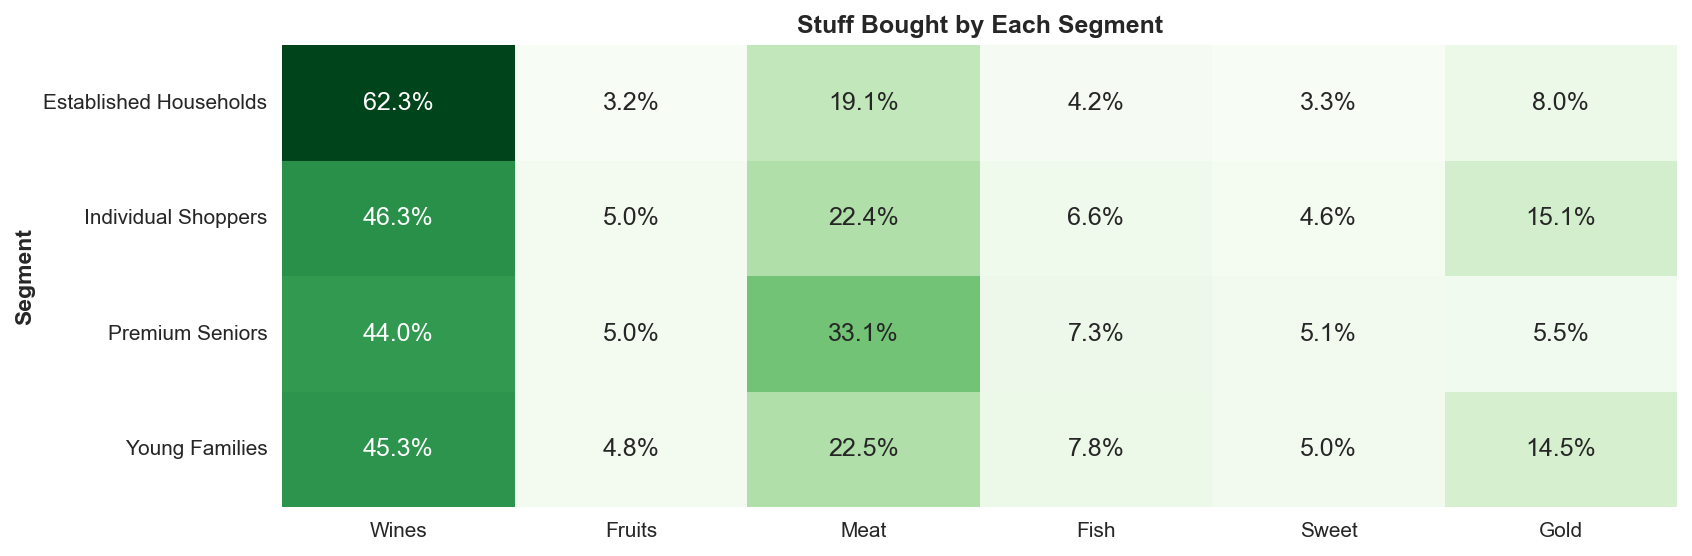

In [1073]:
y= 'segment'

data= (df_clean
    .loc[:, df_clean.columns.str.contains('mnt|segment', regex= True)]
    .groupby(y)
    .mean()
    .apply(lambda x: (x/x.sum()), axis= 'columns')
)

plot_heatmap(data, 'Stuff Bought by Each Segment')

All groups have a strong affinity for wine, with established households showing a particular fondness for it. Moreover, premium seniors are notably enthusiastic about purchasing meat in significant amounts.

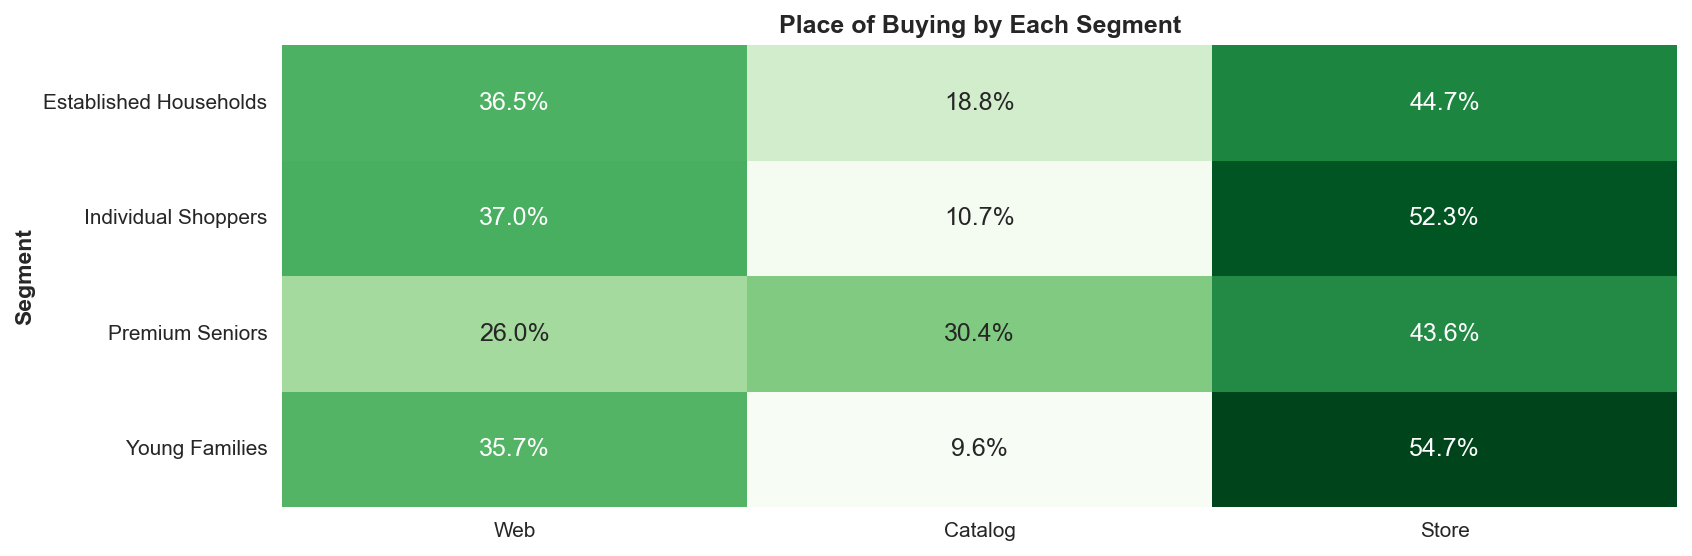

In [1074]:
y= 'segment'

data= (df_clean
    .loc[:, df_clean.columns.str.contains('purchases|segment', regex= True)]
    .drop(columns= 'num_deals_purchases')
    .groupby(y)
    .mean()
    .apply(lambda x: (x/x.sum()), axis= 'columns')
)
plot_heatmap(data, 'Place of Buying by Each Segment')

All the groups show a strong preference for buying products in physical offline stores. Additionally, premium seniors stand out as they enjoy shopping not only on the web and through catalogs but also in physical offline stores.

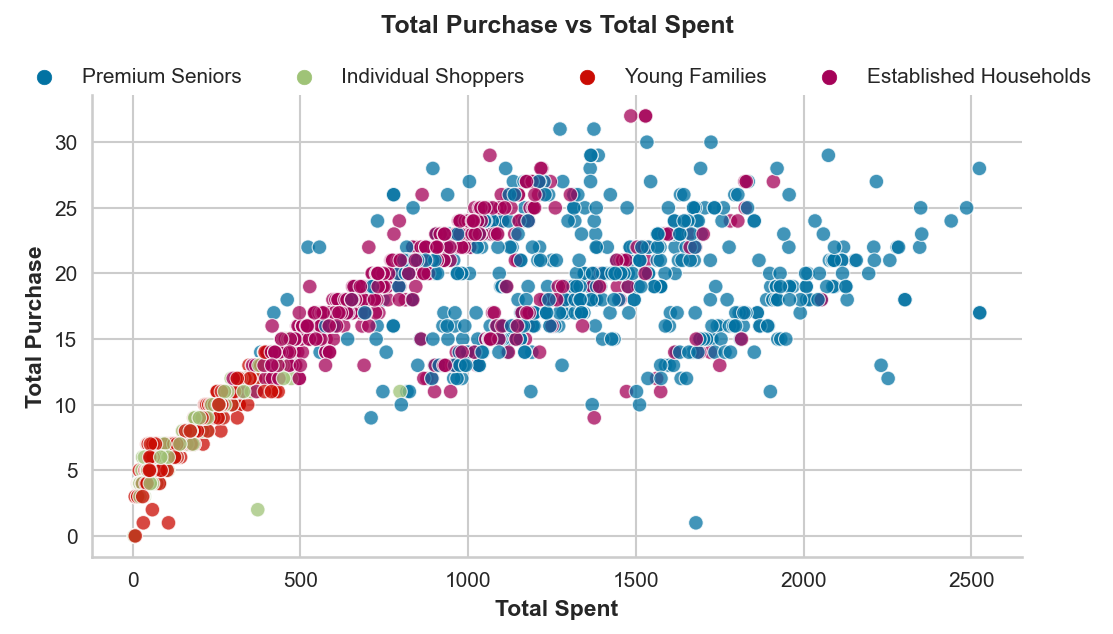

In [1075]:
utils.plot_scatter(
    x= 'total_spent',
    y= 'total_purchase',
    df= df_clean
)

The most fascinating plot, in my view, shows how different groups of shoppers behave. Individual shoppers and young families buy infrequently and opt for more affordable items. On the other hand, established households make frequent purchases of economical products. Remarkably, premium seniors make frequent purchases but lean towards more expensive items.

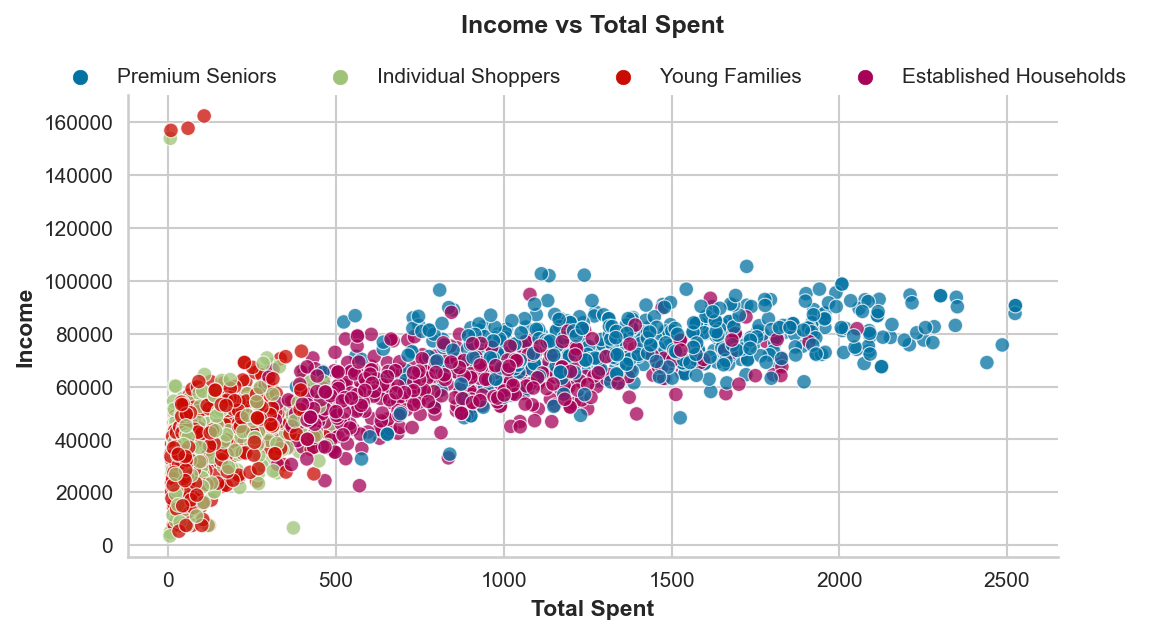

In [1076]:
utils.plot_scatter(
    x= 'total_spent',
    y= 'income',
    df= df_clean
)

# Findings

## Group 0: Young Families
 
- This group mainly includes young couples with lower incomes.
- They have children, indicating they are likely young families with growing responsibilities.
- Members of this group have varied preferences and buy a lot of wines, meat, and gold products.
- They prefer shopping in physical stores rather than online.
- They don't buy very often, but when they do, they tend to choose cheaper products.

### Marketing Strategy:
- Emphasize family-oriented messaging that resonates with young couples and their growing responsibilities.
- Highlight affordable product options, discounts, and promotions to attract price-conscious consumers.
- Use social media platforms and targeted online ads to reach this tech-savvy group.
- Offer in-store exclusive deals and create a warm and welcoming shopping atmosphere for families.
- Collaborate with parenting blogs and influencers to promote family-friendly products.

### Sales Strategy:
- Train sales representatives to be knowledgeable about the preferences of young families and recommend suitable products.
- Offer loyalty programs to encourage repeat purchases and customer retention.
- Provide flexible payment options and installment plans to accommodate lower incomes.
- Organize family-oriented events and workshops in physical stores to engage with this group.
- Use customer feedback to continuously improve products and services based on their evolving needs.

## Group 1: Premium Seniors

- Most members of this group are couples with high incomes.
- They have a wide age range, with many being older individuals or retirees.
- They don't have children, suggesting they are likely retired or in advanced - career stages.
- Members of this group shop using various methods, including online, catalogs, and in-store.
- They spend a lot on high-end products, showing a preference for luxury items.

### Marketing Strategy:
- Position products as premium and high-quality to appeal to the refined tastes of this group.
- Use sophisticated and elegant branding to target an older, discerning audience.
- Leverage online advertising, catalogs, and in-store displays to reach this diverse audience.
- Create exclusive membership programs with personalized offers for premium services.
- Collaborate with luxury lifestyle influencers and celebrities to endorse the brand.

### Sales Strategy:
- Train sales representatives to provide top-notch customer service and personalized assistance.
- Offer premium packaging and gift-wrapping services to enhance the shopping experience.
- Provide exclusive previews and early access to new products for members.
- Organize events and private shopping sessions for this group to showcase new collections.
- Implement a hassle-free return policy and offer complimentary alterations for high-end items.


## Group 2: Established Household

- This group is mostly composed of families with moderate incomes.
- They are in their middle-aged years, indicating established families with children.
- The main focus of this group is on buying wines.
- They enjoy both online and in-store shopping for convenience.
- They are mindful of costs and make significant purchases of affordable - products.

### Marketing Strategy:
- Highlight wines as the main focus of this group's interest and offer wine-related promotions and events.
- Utilize targeted online ads and email campaigns to reach middle-aged families effectively.
- Showcase a variety of affordable products, including family essentials and budget-friendly options.
- Offer bundle deals and family-sized packages to appeal to their household needs.
- Collaborate with food and lifestyle bloggers to promote family-friendly recipes and products.

### Sales Strategy:
- Provide in-store wine tastings and product demonstrations to engage with this group.
- Offer discounts for bulk purchases and encourage loyal customers with reward programs.
- Implement a user-friendly online shopping experience with easy navigation and customer reviews.
- Offer a subscription service for regularly purchased items to ensure customer loyalty.
- Ensure efficient customer service and prompt resolution of any issues or concerns.

## Group 3: Individual Shoppers

- This group consists of individuals without partners and with lower incomes.
- They are typically in their middle-aged years, representing various life stages and experiences.
- Having children, they may be single parents or actively involved in family responsibilities.
- Members of this group have diverse shopping patterns, buying wines, meat, and gold items.
- They like the flexibility of both online and in-store shopping.
- Their spending habits are moderate, preferring affordable products and making restrained purchases of cheaper items.

### Marketing Strategy:
- Appeal to the independence and flexibility of individual shoppers in marketing messages.
- Utilize targeted online advertising and social media platforms to reach this group effectively.
- Offer a wide variety of products to cater to their diverse shopping preferences.
- Create online-exclusive deals and discounts to attract tech-savvy shoppers.
- Collaborate with lifestyle bloggers and content creators to showcase versatile products.

### Sales Strategy:
- Provide personalized recommendations and product suggestions based on their diverse preferences.
- Offer a hassle-free online shopping experience with easy returns and exchanges.
- Implement a user-friendly mobile app for on-the-go shopping convenience.
- Utilize customer reviews and ratings to build trust and aid in decision-making.
- Provide regular updates on new arrivals and product recommendations through email newsletters.